
# PyTorch를 이용한 인공지능 실습 - 사진 분류기

### 0.딥러닝?

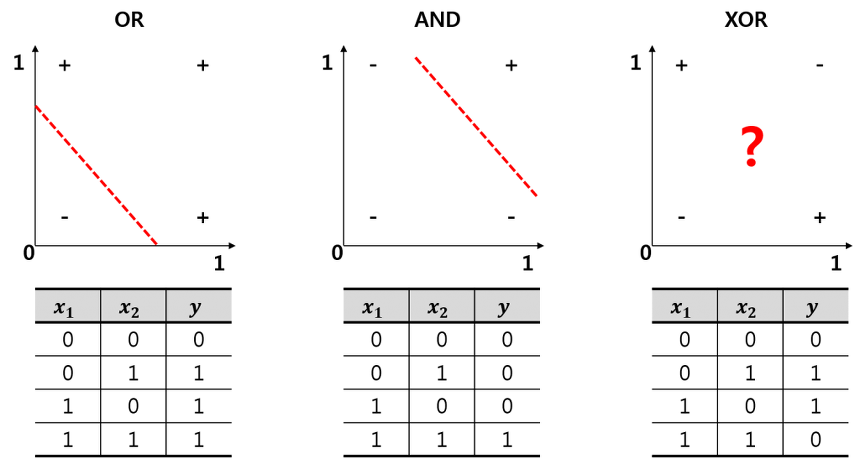

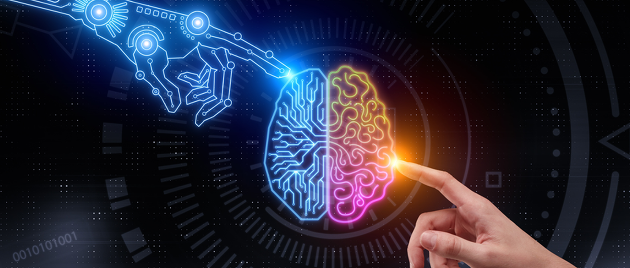

### 1.다층 퍼셉트론 (Multi-layer Perceptron) 이란?
<p align="center">
<img src="https://docs.google.com/uc?export=download&id=1IMQgUtniLXb9TxrMnkcIPWYekWxU7tTz" alt="no_image" width="800px"/> 
</p>

- 다층 퍼셉트론은 그림과 같이 입력층(input layer)과 출력층(output layer)사이에 한 개 이상의 중간층(은닉층, hidden layer)을 사용하여 여러 층으로 구성하는 신경망입니다.
- 입력층으로부터 출력층으로 한방향으로만 활성화되어 신호가 전달되기 때문에 순방향망(feed-forward network)라고도 부릅니다.
- 다층 퍼셉트론은 중간층에서 비선형 함수(활성화 함수)를 사용하기 때문에, 단층 퍼셉트론과 달리 비선형 데이터에서도 잘 작동합니다.




### 2.Activation Function 비선형 함수(활성화 함수) 

<p align="center">
<img src="https://docs.google.com/uc?export=download&id=1X2O4iUXsRXEr0Cr4Q4vYjUjR5ydwxoeT" alt="no_image" width="800px"/> 
</p>

- 대표적인 비선형 함수에는 다음 함수들이 있습니다.
    - ReLU (Rectified Linear Unit)      
    - Sigmoid     
    - Tanh
- 단층 퍼셉트론은 선형모델이기 때문에 비선형 데이터에 적용하기 어렵습니다.
- 반면, 다층 퍼셉트론은 중간층(은닉층, hidden layer)에서 비선형 함수를 사용하기 때문에 비선형 데이터를 잘 처리할 수 있습니다.


**이번 실습에서는 시그모이드 함수와 ReLU함수를 활성화 함수로 사용할 것입니다.**

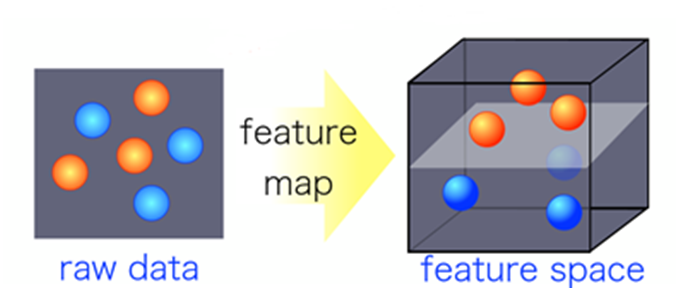

## 3. PyTorch를 이용한 사진 분류기(순방향 다층 퍼셉트론) 구현


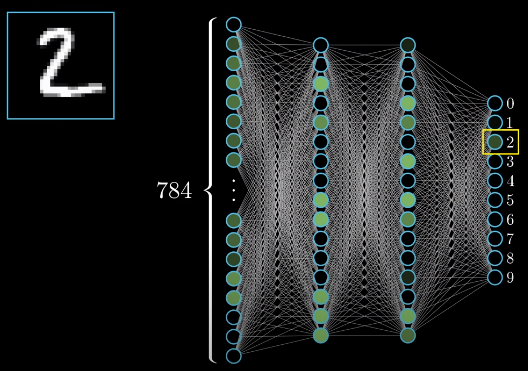

### Steps

PyTorch를 이용하여 모델을 구현하고 훈련하는 과정은 아래와 같이 크게 다섯 단계로 나눌 수 있습니다.

- Step 1: 모델(다층 퍼셉트론) 훈련에 사용할 데이터셋 불러오기 및 사용 준비합니다.
- Step 2: 모델 사용 준비합니다.
- Step 3: 학습 손실함수(Loss)를 준비합니다.
- Step 4: 학습 최적화를 위한 도구(Optimizer)를 준비합니다.
- Step 5: 모델을 학습합니다.

### Step 1.(a): MNIST 학습 데이터셋 불러오기
#### MNIST 데이터셋

- 총 10종류의 정답을 가지는 사진(image)과 정답 (label)으로 구성된 데이터셋 (0,1,2,3,4,5,6,7,8,9) 입니다.
- 학습 데이터는 28 x 28 크기의 흑백(1 channel) 이미지입니다.
- 학습 데이터 60000개 / 테스트 데이터 10000개로 구성되어 있습니다.

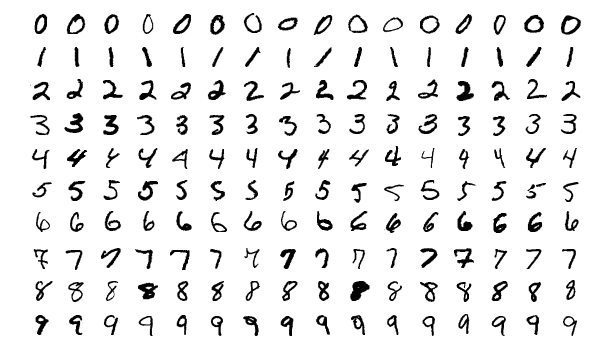

In [ ]:
# 필요한 모듈 불러오기
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.nn.functional as F

%matplotlib inline  
plt.style.use('default')

**학습 데이터셋 준비 및 개수 확인**

In [ ]:
#데이터셋
transform_train = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (1.0,)),
])

train_dataset = dsets.MNIST(root='./data/MNIST/', 
                            train=True, 
                            transform= transform_train,
                            download=True)

len(train_dataset)

60000

### Step 1(b): 테스트 데이터셋 불러오기
- 테스트 데이터셋은 모델이 잘 학습되었는지 확인하기 위한 데이터셋입니다.
- 학습 데이터셋이 기출문제라면, 테스트 데이터셋은 실제 시험으로 볼 수 있습니다.

**테스트 데이터 준비 및 개수 확인**

In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,)),
])

test_dataset = dsets.MNIST(root='./data/MNIST/', 
                           train=False, 
                           transform=transform_test)
len(test_dataset)

10000

### Step 1(c): 데이터셋 사용 준비
- 데이터 관련 hyperparameter를 설정합니다.
    - hyperparameter: 일반적으로 머신러닝에서 모델을 학습시킬때, 사람이 직접 설정해야하는 변수를 의미합니다.

<p align="center">
<img src="https://docs.google.com/uc?export=download&id=17zyniKhbpBFm6BTb-6gVbFbpw97q9lBV" alt="no_image" width="400px";/> 
</p>

- **total data**: 60000
- **mini-batch**: 100
    - 학습 1회(iteration)에 사용할 데이터 개수를 뜻합니다.
- **iterations**: 6000
    - 1 iteration: 하나의 mini-batch가 학습되는 단위입니다.
- **epoch**

    - 1 epoch: 전체 학습 데이터가 학습되는 단위입니다.

##### **Mini-batch의 크기와 iterations**

50000개의 데이터를 작은 그룹(mini-batch)로 나누어서 학습을 진행합니다.

작은 그룹으로 나누어서 학습을 진행하는 이유는?

> 1. 메모리 문제: 50000개 전체를 한 번에 사용하면 많은 메모리가 요구되어 메모리가 부족한 오류가 발생할 수 있습니다.
> 2. 불안정한 학습: 50000개의 데이터에 대한 손실을 한번에 학습에 사용하는 것보다 작은 그룹으로 나누어 학습을 하는 것이 더 효율적이고 안정적입니다.  



Hyper-Parameters

In [ ]:
batch_size = 100
num_epochs = 15

In [ ]:
print('STEP 1: 데이터셋 사용준비 완료')

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=1, 
                                          shuffle=False)

class_names = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

STEP 1: 데이터셋 사용준비 완료


## Step 2: 모델(다층 퍼셉트론) 모델 사용 준비

**model class**
- 이번 실습에서는 MLP를 활용하여 이미지 분류를 실습합니다.

input_dim(입력층 뉴런 개수), hidden_dim (중간층 뉴런 개수), class_cardinality(출력층 뉴런 개수; 총 클래스 갯수), activation(활성화 함수 종류)

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, class_cardinality, activation):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, class_cardinality)
        
        if activation == "sigmoid":
            self.activation = torch.nn.Sigmoid()
        elif activation == "relu":
            self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        x = torch.reshape(x, (x.size(0), -1))
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return F.log_softmax(x)

### Model A: 중간층 1개의 다층 퍼셉트론 

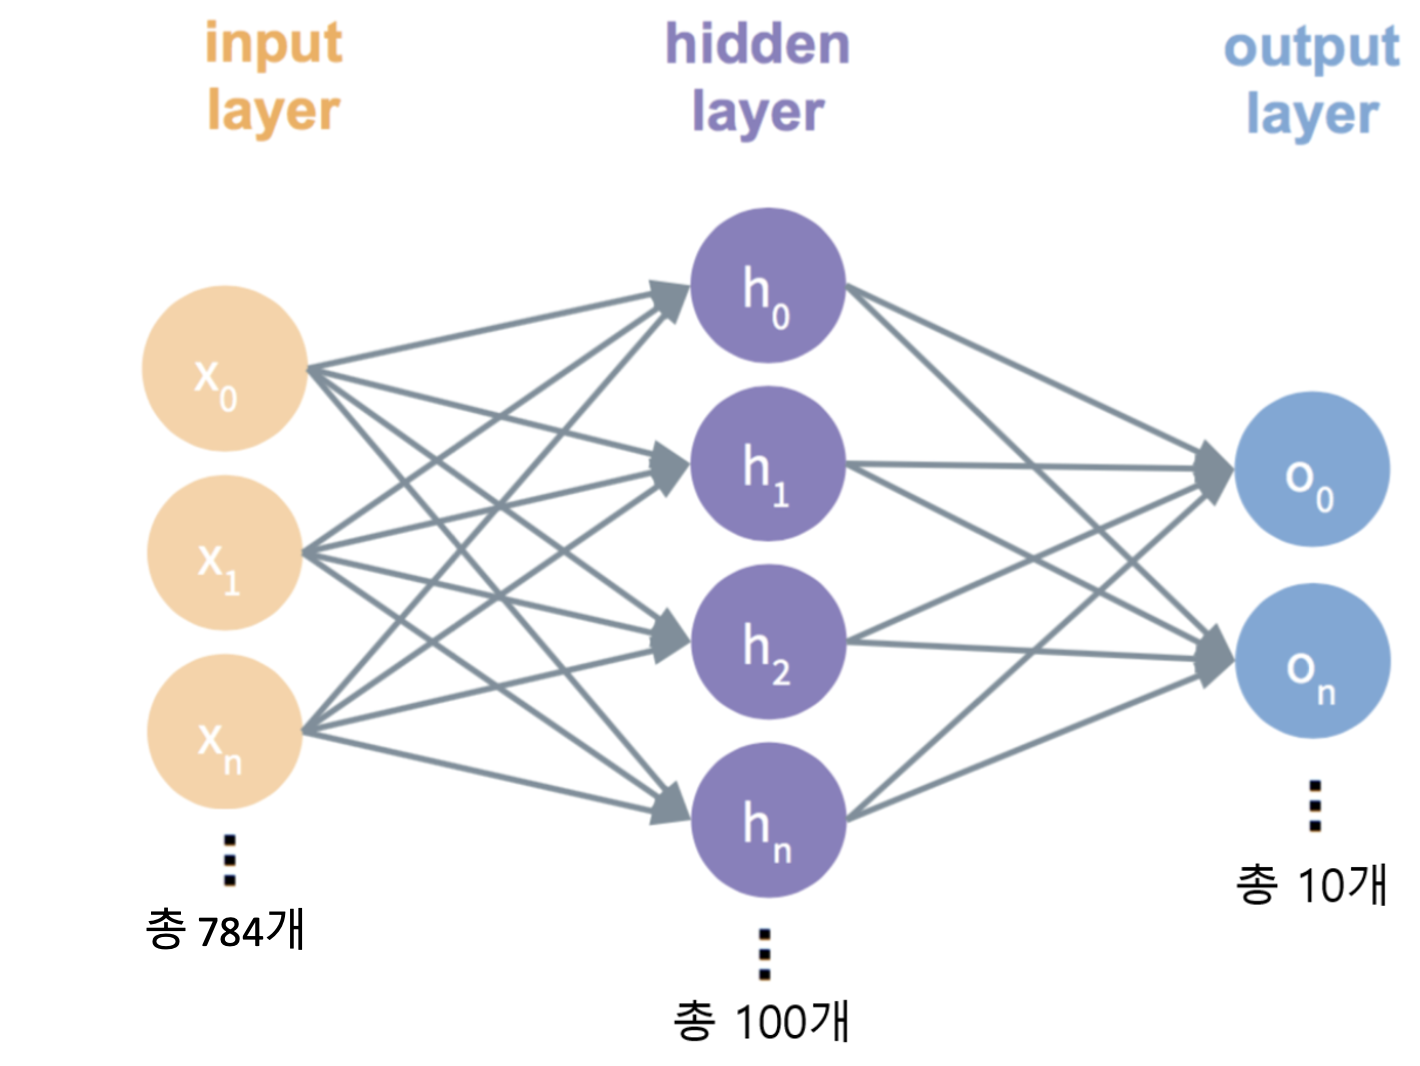
- 모델을 정의하기 위한 변수를 설정하고 사용을 준비합니다.

- **Input** 뉴런 개수: **784** 
    - 이미지 사이즈 * 이미지 채널수로 설정합니다.
     \begin{equation}28 \times 28 \times 1 = 784\end{equation}
- **Output** 뉴런 개수: **10**
    - 데이터셋의 정답 종류 개수(클래스 개수) 입니다.
    - 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
- **Hidden** 뉴런 개수: **100**
    - 앞에서 알아본 hyperparameter로, 사용자가 원하는 숫자로 설정하여 사용할 수 있습니다.
    - 이 숫자에 따라 모델의 크기가 정해집니다.

- **Activation** 종류: **"ReLU" / "Sigmoid" / ...**

In [ ]:
#모델 변수 설정
input_dim = 28 * 28 * 1
hidden_dim = 100
class_cardinality = 10
activation = "relu"

### 모델 사용 준비 ###
model = Net(input_dim, hidden_dim, class_cardinality, activation)
###################

### Step 3: 손실 함수 준비

- 일반적으로 분류(classification)문제를 해결할 때 사용하는 손실함수인 Cross Entropy Loss 함수를 사용합니다.
   

In [ ]:
### 손실함수 (Loss Function) 준비 ###
criterion = torch.nn.CrossEntropyLoss()
##################

### Step 4: 최적화 도구 Optimizer 준비

- 경사하강법을 이용한 모델 학습식은 다음과 같습니다.
     \begin{equation}\theta \leftarrow \theta - \eta \cdot \nabla_\theta \end{equation}
    - $\theta$: 학습 파라미터 
    - $\eta$: 학습 속도 (learning rate, hyperparameter)
    - $\nabla_\theta$: 학습 파라미터 기울기 (미분 값)
- 정리하면,
    - `파라미터 <= 파라미터 - 학습속도 X 기울기`
    - 우리는 $y=x^2$대신 **step 3**의 손실 함수를 사용하는 것이고, $x$대신 $\theta$(학습 파라미터)를 사용하는 것입니다.
    - 매 iteration마다 이 과정을 통해 모델을 학습합니다.


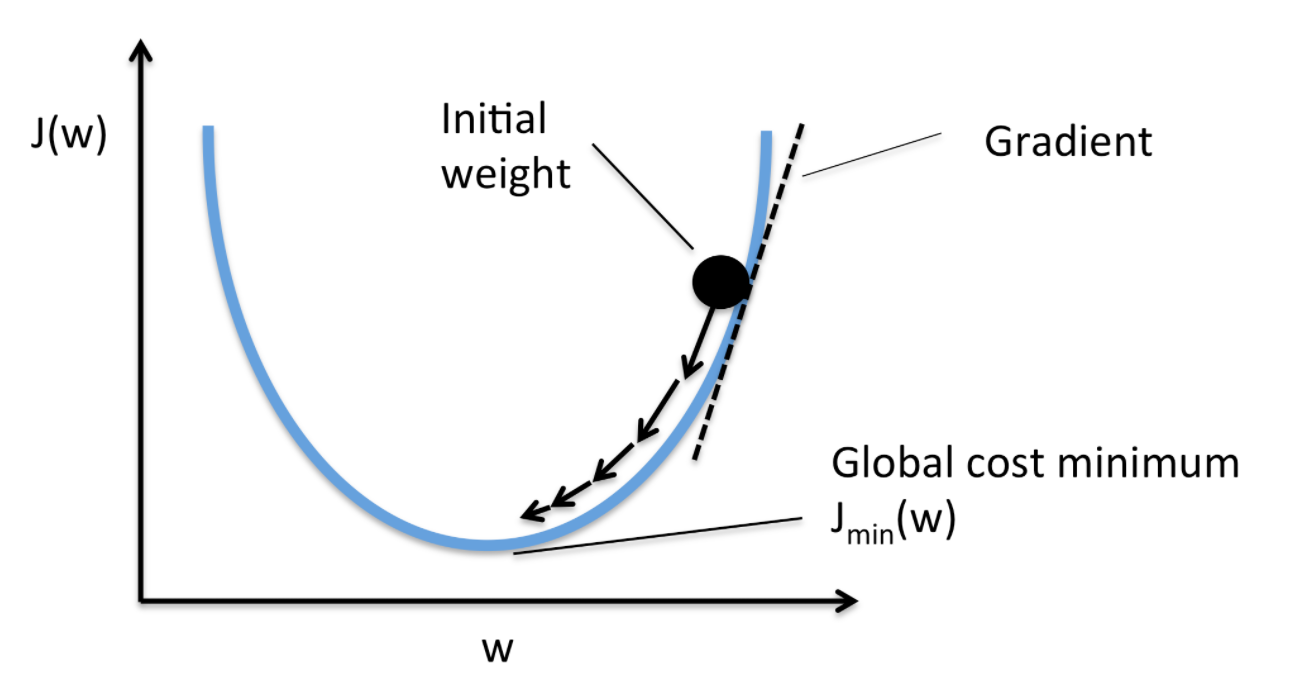

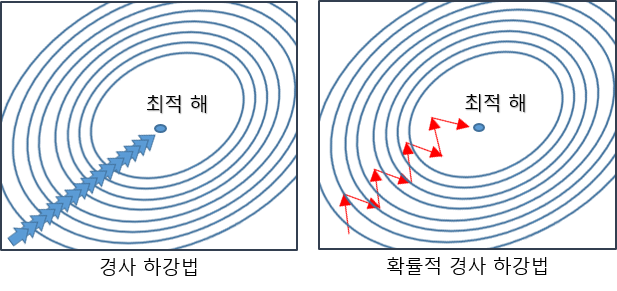

In [ ]:
#학습 속도 설정
learning_rate = 0.1

### 최적화도구 준비 ###
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
###################

### Step 5: 모델 학습 / 테스트 

**학습의 7단계**

 - Steps
    1. 입력(이미지) / label(정답) 사용을 준비합니다.
    2. 학습 파라미터 기울기 값을 초기화합니다.
    3. 모델에 입력 통과 (순방향 전파)시켜 예측값을 생성합니다.
    4. 정답과 예측값 사이의 손실함수를 계산합니다.
    5. 손실함수를 토대로 학습 파라미터 기울기 값을 계산합니다.
    6. 학습 파라미터를 앞에서 배운 식으로 업데이트합니다.
        - `파라미터 <= 파라미터 - 학습속도 X 기울기`
    7. 학습이 완료될 때까지 반복합니다.

In [ ]:
for epoch in range(num_epochs):
    #학습
    model.train()
    start = time.time()
    for i, (images, labels) in enumerate(train_loader):
                
        ### 학습 파라미터 기울기 값 0으로 초기화 ###
        optimizer.zero_grad()
        ####################################


        #### 모델에 입력을 통과 (순방향) / 출력(예측 label) ###
        outputs = model(images)
        ###############################################


        ### 정답과 예측값 사이의 손실함수 계산 ###
        loss = criterion(outputs, labels)
        ##################################


        #### 학습 파라미터들의 기울기 값 계산 ###
        loss.backward()
        #################################


        ### 학습 파라미터 업데이트(파라미터 <= 파라미터 - 학습속도 * 기울기) ###
        optimizer.step()
        ##########################################################
    
    # 테스트
    end = time.time()
    model.eval()

    # 정확도 측정을 위한 변수         
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
               
            # 순방향 전파
            outputs = model(images)

            # 예측값 (label)
            _, predicted = torch.max(outputs.data, 1)

            # 테스트 전체 개수
            total += labels.size(0)

            # 테스트 중 맞은 개수
            correct += (predicted == labels).sum()
        
        #정확도 측정
        accuracy = 100 * correct.item() / total

        # 학습 손실함수 및 정확도 출력
        print('Epochs: {}. Loss: {}. Accuracy: {}. Elapsed time: {} sec'.format(epoch, loss.item(), accuracy, end-start))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: ignored

In [ ]:
# 시각화 하기위한 함수 
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    return inp

### 테스트 결과 시각화 
초록색 글씨는 맞은 예측을, 빨간색 글씨는 틀린 예측을 의미합니다.

In [ ]:
fig = plt.figure(figsize=(30,12))
for i, (images, labels) in enumerate(test_loader):
    if i+1 > 32:
        break
        
    outputs = model(images)
    ax = fig.add_subplot(4, 8, i+1, xticks=[], yticks=[])
    ax.imshow(imshow(images[0]))
    _, pred = torch.max(outputs.data, 1)
    ax.set_title("{} ({})".format(class_names[pred], class_names[labels]),
                 color = ("green" if pred == labels else "red"))